In [1]:
import numpy as np
import tensorflow as tf
import imageio
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import data_tool

In [2]:
"""
Hyper-parameters
"""
# different minibatch size for different resolution
minibatch_dict = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8}
# number of channels, 1 for gray images, 3 for RGB images
num_channels = 1
# number of feature maps
nf = 128
# resolution of raw images
resolution = 32
resolution_log2 = int(np.log2(resolution))
init_resolution = 4
# dimension of latent space
z_dim = 128
# number of images used in a phase
dur_nimg = 300000
# number of images used in total
total_nimg = 2400000

# number of images for visualizing
num_row = 10
num_line = 10

In [3]:
# a function for visualizing
def montage(images, grid):

    s = np.shape(images)
    assert s[0] == np.prod(grid) and np.shape(s)[0] == 4
    bigimg = np.zeros((s[1]*grid[0], s[1]*grid[1], s[3]), dtype=np.float32)

    for i in range(grid[0]):
        for j in range(grid[1]):
            bigimg[s[1] * i : s[1] * i + s[1], s[1] * j : s[1] * j + s[1]] += images[grid[1] * i + j]

    return np.rint(bigimg*255).clip(0, 255).astype(np.uint8)

In [4]:
# calculate coefficients with given divergence
def coef_div(d_score, div):

    if div == 'KL':
        s = np.ones_like(d_score)
    elif div == 'Logd':
        s = 1 / (1 + np.exp(d_score))
    elif div == 'JS':
        s = 1 / (1 + np.exp(-d_score))
    elif div == 'Jef':
        s = 1 + np.exp(d_score)

    return np.reshape(s, [-1, 1, 1, 1])

In [5]:
def lod(num_img):

    ph_num = num_img // (2*dur_nimg)
    remain_num = num_img - ph_num * (2*dur_nimg)

    if np.log2(resolution/init_resolution) <= ph_num:
        return 0.
    elif remain_num <= dur_nimg:
        return np.log2(resolution/init_resolution) - ph_num
    else: 
        return np.log2(resolution/init_resolution) - ph_num - (remain_num - dur_nimg) / dur_nimg

In [6]:
# define functions for convenience

def lerp(a, b, t):
    with tf.name_scope('Lerp'):
        return a + (b - a) * t
    
def lerp_clip(a, b, t): return a + (b - a) * tf.clip_by_value(t, 0.0, 1.0)

def cset(cur_lambda, new_cond, new_lambda): return lambda: tf.cond(new_cond, new_lambda, cur_lambda)

def get_weight(shape, gain=np.sqrt(2), use_wscale=False, fan_in=None):
    if fan_in is None: fan_in = np.prod(shape[:-1])
    std = gain / np.sqrt(fan_in) # He init
    if use_wscale:
        wscale = tf.constant(np.float32(std), name='wscale')
        return tf.get_variable('weight', shape=shape, initializer=tf.initializers.random_normal()) * wscale
    else:
        return tf.get_variable('weight', shape=shape, initializer=tf.initializers.random_normal(0, std))

def dense(x, fmaps, gain=np.sqrt(2), use_wscale=False):
    if len(x.shape) > 2:
        x = tf.reshape(x, [-1, np.prod([d.value for d in x.shape[1:]])])
    w = get_weight([x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale)
    w = tf.cast(w, x.dtype)
    return tf.matmul(x, w)

def conv2d(x, fmaps, kernel, gain=np.sqrt(2), use_wscale=False):
    assert kernel >= 1 and kernel % 2 == 1
    w = get_weight([kernel, kernel, x.shape[3].value, fmaps], gain=gain, use_wscale=use_wscale)
    w = tf.cast(w, x.dtype)
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME', data_format='NHWC')

def apply_bias(x):
    if len(x.shape) == 2:
        b = tf.get_variable('bias', shape=[x.shape[1]], initializer=tf.initializers.zeros())
        b = tf.cast(b, x.dtype)
        return x + b
    else:
        b = tf.get_variable('bias', shape=[x.shape[3]], initializer=tf.initializers.zeros())
        b = tf.cast(b, x.dtype)
        return x + tf.reshape(b, [1, 1, 1, -1])

def leaky_relu(x, alpha=0.2):
    with tf.name_scope('LeakyRelu'):
        alpha = tf.constant(alpha, dtype=x.dtype, name='alpha')
        return tf.maximum(x * alpha, x)

def upscale2d(x, factor=2):
    assert isinstance(factor, int) and factor >= 1
    if factor == 1: return x
    with tf.variable_scope('Upscale2D'):
        s = x.shape
        x = tf.reshape(x, [-1, s[1], 1, s[2], 1, s[3]])
        x = tf.tile(x, [1, 1, factor, 1, factor, 1])
        x = tf.reshape(x, [-1, s[1] * factor, s[2] * factor, s[3]])
        return x

# def upscale2d_conv2d(x, fmaps, kernel, gain=np.sqrt(2), use_wscale=False):
#     assert kernel >= 1 and kernel % 2 == 1
#     w = get_weight([kernel, kernel, fmaps, x.shape[3].value], gain=gain, use_wscale=use_wscale, fan_in=(kernel**2)*x.shape[3].value)
#     w = tf.pad(w, [[1,1], [0,0], [0,0], [1,1]], mode='CONSTANT')
#     w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]])
#     w = tf.cast(w, x.dtype)
#     os = [tf.shape(x)[0], x.shape[1] * 2, x.shape[2] * 2, fmaps]
#     return tf.nn.conv2d_transpose(x, w, os, strides=[1,2,2,1], padding='SAME', data_format='NHWC')

def downscale2d(x, factor=2):
    assert isinstance(factor, int) and factor >= 1
    if factor == 1: return x
    with tf.variable_scope('Downscale2D'):
        ksize = [1, factor, factor, 1]
        return tf.nn.avg_pool(x, ksize=ksize, strides=ksize, padding='VALID', data_format='NHWC')

# def conv2d_downscale2d(x, fmaps, kernel, gain=np.sqrt(2), use_wscale=False):
#     assert kernel >= 1 and kernel % 2 == 1
#     w = get_weight([kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale)
#     w = tf.pad(w, [[1,1], [1,1], [0,0], [0,0]], mode='CONSTANT')
#     w = tf.add_n([w[1:, 1:], w[:-1, 1:], w[1:, :-1], w[:-1, :-1]]) * 0.25
#     w = tf.cast(w, x.dtype)
#     return tf.nn.conv2d(x, w, strides=[1,1,2,2], padding='SAME', data_format='NCHW')

def pixel_norm(x, epsilon=1e-8):
    with tf.variable_scope('PixelNorm'):
        return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=3, keepdims=True) + epsilon)

In [7]:
def generator(latents_in, lod_in, use_wscale = True, use_pixelnorm = True, reuse = None):

    with tf.variable_scope('generator', reuse=reuse):
        def PN(x): return pixel_norm(x) if use_pixelnorm else x

        # Building blocks.
        def block(x, res): # res = 2..resolution_log2
            with tf.variable_scope('%dx%d' % (2**res, 2**res)):
                if res == 2: # 4x4
                    with tf.variable_scope('Dense'):
                        x = dense(x, fmaps=nf*16, gain=np.sqrt(2)/4, use_wscale=use_wscale)
                        x = tf.reshape(x, [-1, 4, 4, nf])
                        x = PN(leaky_relu(apply_bias(x)))
                    with tf.variable_scope('Conv'):
                        x = PN(leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=3, use_wscale=use_wscale))))
                else: # 8x8 and up
                    x = upscale2d(x)
                    with tf.variable_scope('Conv0'):
                        x = PN(leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=3, use_wscale=use_wscale))))
                    with tf.variable_scope('Conv1'):
                        x = PN(leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=3, use_wscale=use_wscale))))
                return x
        def torgb(x, res): # res = 2..resolution_log2
            lod = resolution_log2 - res
            with tf.variable_scope('ToRGB_lod%d' % lod, reuse=tf.AUTO_REUSE):
                return apply_bias(conv2d(x, fmaps=num_channels, kernel=1, gain=1, use_wscale=use_wscale))

        def grow(x, res, lod): # here we use a recursive structure which is faster than normal structure
            y = block(x, res)
            img = lambda: upscale2d(torgb(y, res), 2**lod)
            if res > 2: img = cset(img, (lod_in > lod), lambda: upscale2d(lerp(torgb(y, res), upscale2d(torgb(x, res - 1)), lod_in - lod), 2**lod))
            if lod > 0: img = cset(img, (lod_in < lod), lambda: grow(y, res + 1, lod - 1))
            return img()
        images_out = grow(latents_in, 2, resolution_log2 - 2)
        
    images_out = tf.identity(images_out, name='images_out')
    return images_out

In [8]:
def discriminator(images_in, lod_in, use_wscale = True, reuse = None):

    with tf.variable_scope('discriminator', reuse=reuse):

        def fromrgb(x, res): # res = 2..resolution_log2
            with tf.variable_scope('FromRGB_lod%d' % (resolution_log2 - res), reuse=tf.AUTO_REUSE):
                return leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=1, use_wscale=use_wscale)))
        def block(x, res): # res = 2..resolution_log2
            with tf.variable_scope('%dx%d' % (2**res, 2**res)):
                if res >= 3:
                    with tf.variable_scope('Conv0'):
                        x = leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=3, use_wscale=use_wscale)))
                    with tf.variable_scope('Conv1'):
                        x = leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=3, use_wscale=use_wscale)))
                    x = downscale2d(x)
                else: # 4x4
                    with tf.variable_scope('Conv'):
                        x = leaky_relu(apply_bias(conv2d(x, fmaps=nf, kernel=3, use_wscale=use_wscale)))
                    with tf.variable_scope('Dense0'):
                        x = leaky_relu(apply_bias(dense(x, fmaps=nf, use_wscale=use_wscale)))
                    with tf.variable_scope('Dense1'):
                        x = apply_bias(dense(x, fmaps=1, gain=1, use_wscale=use_wscale))
                return x
    
        def grow(res, lod):
            x = lambda: fromrgb(downscale2d(images_in, 2**lod), res)
            if lod > 0: x = cset(x, (lod_in < lod), lambda: grow(res + 1, lod - 1))
            x = block(x(), res); y = lambda: x
            if res > 2: y = cset(y, (lod_in > lod), lambda: lerp(x, fromrgb(downscale2d(images_in, 2**(lod+1)), res - 1), lod_in - lod))
            return y()
        scores_out = grow(2, resolution_log2 - 2)

    scores_out = tf.identity(scores_out, name='scores_out')
    return scores_out

In [9]:
"""
pre-process real images
"""

def downscale(img):
    s = img.shape
    out = np.reshape(img, [-1, s[1], s[2]//2, 2, s[3]//2, 2])
    return np.mean(out, axis=(3, 5))

def upscale(img):
    return np.repeat(np.repeat(img, 2, axis=2), 2, axis=3)

def process_real(x, lod_in):
    y = x / 127.5 - 1
    alpha = lod_in - np.floor(lod_in)
    y = (1 - alpha)*y + alpha*upscale(downscale(y))
    for i in range(int(np.floor(lod_in))):
        y = upscale(y)
    return y.transpose([0, 2, 3, 1])

In [10]:
"""
bulid graph
"""

x_p    = tf.placeholder(dtype=tf.float32, shape=[None, resolution, resolution, num_channels], name='images')
z_p    = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='latents')
G_z_p  = tf.placeholder(dtype=tf.float32, shape=[None, resolution, resolution, num_channels], name='particles')
lod_in = tf.placeholder(dtype=tf.float32, shape=[], name='level_of_details')

G_z   = generator(z_p, lod_in)

# discriminator loss:
d_real_logits = discriminator(x_p, lod_in)
d_fake_logits = discriminator(G_z_p, lod_in, reuse=True)
loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
loss_d = loss_d_real + loss_d_fake

# generator loss:
loss_g = 0.5 * tf.reduce_mean(tf.reduce_sum((G_z - G_z_p)**2))

# computing gradient:
d_grad = tf.gradients(d_fake_logits, G_z_p)[0]

# optimizers:
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

optimizer_d = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.0, beta2=0.99, epsilon=1e-8, name='opt_d')
update_d    = optimizer_d.minimize(loss_d, var_list=vars_d)

optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.0, beta2=0.99, epsilon=1e-8, name='opt_g')
update_g    = optimizer_g.minimize(loss_g, var_list=vars_g)

reset_optimizer_d = tf.variables_initializer(optimizer_d.variables())
reset_optimizer_g = tf.variables_initializer(optimizer_g.variables())

# KL divergence:

num_img: 50176    |  lod_in: 3.00   |  D real loss: 0.657249   |  D fake loss: 0.594826   |  Projection loss: 9.352760


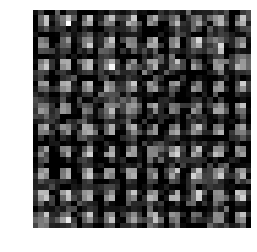

num_img: 100352    |  lod_in: 3.00   |  D real loss: 0.677281   |  D fake loss: 0.626851   |  Projection loss: 48.147778


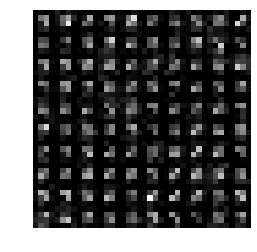

num_img: 150528    |  lod_in: 3.00   |  D real loss: 0.773100   |  D fake loss: 0.589253   |  Projection loss: 140.634308


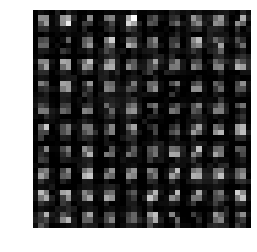

num_img: 200704    |  lod_in: 3.00   |  D real loss: 0.732848   |  D fake loss: 0.629893   |  Projection loss: 50.007618


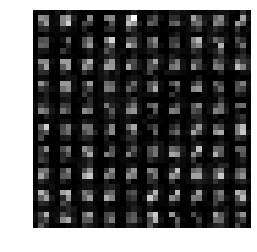

num_img: 250880    |  lod_in: 3.00   |  D real loss: 0.749142   |  D fake loss: 0.600148   |  Projection loss: 93.115540


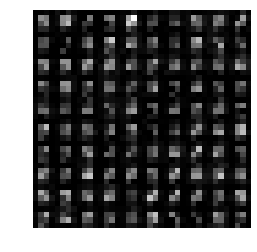

num_img: 301056    |  lod_in: 3.00   |  D real loss: 0.754285   |  D fake loss: 0.601228   |  Projection loss: 100.823883


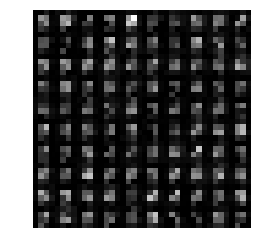

num_img: 351232    |  lod_in: 2.83   |  D real loss: 0.748338   |  D fake loss: 0.596507   |  Projection loss: 449.084808


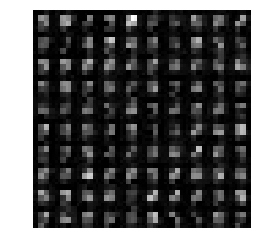

num_img: 401408    |  lod_in: 2.66   |  D real loss: 0.711391   |  D fake loss: 0.582676   |  Projection loss: 1035.215820


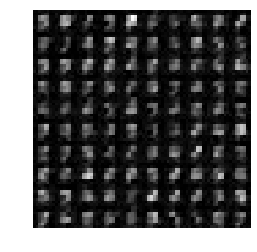

num_img: 451584    |  lod_in: 2.49   |  D real loss: 0.764888   |  D fake loss: 0.546376   |  Projection loss: 115.455971


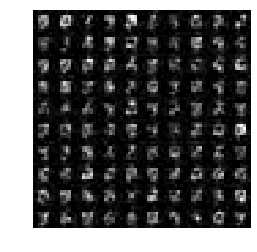

num_img: 501760    |  lod_in: 2.33   |  D real loss: 0.590314   |  D fake loss: 0.553946   |  Projection loss: 14084.576172


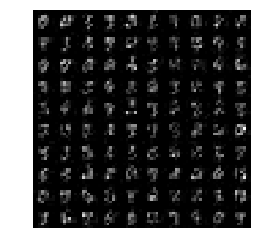

num_img: 551936    |  lod_in: 2.16   |  D real loss: 0.789954   |  D fake loss: 0.395411   |  Projection loss: 5785.955078


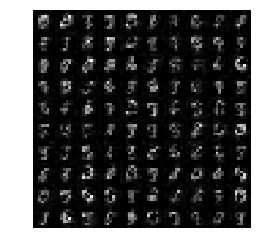

num_img: 602112    |  lod_in: 2.00   |  D real loss: 0.276091   |  D fake loss: 0.915123   |  Projection loss: 2804.097900


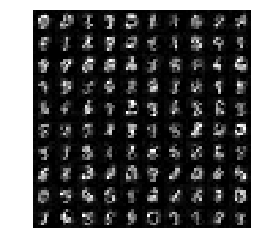

num_img: 652288    |  lod_in: 2.00   |  D real loss: 0.292610   |  D fake loss: 0.941672   |  Projection loss: 1729.743652


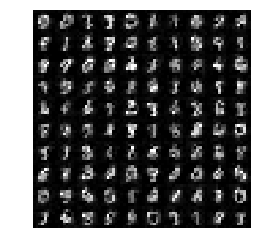

num_img: 702464    |  lod_in: 2.00   |  D real loss: 0.629969   |  D fake loss: 0.446945   |  Projection loss: 8528.890625


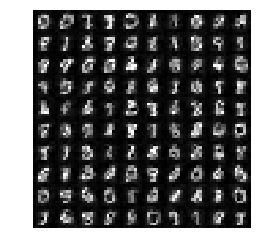

num_img: 752640    |  lod_in: 2.00   |  D real loss: 0.841905   |  D fake loss: 0.400575   |  Projection loss: 269.677216


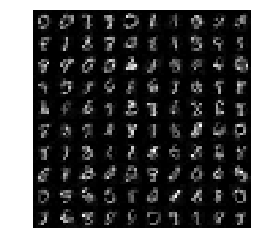

num_img: 802816    |  lod_in: 2.00   |  D real loss: 0.772091   |  D fake loss: 0.433855   |  Projection loss: 902.964233


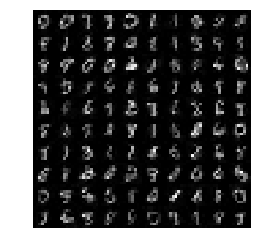

num_img: 852992    |  lod_in: 2.00   |  D real loss: 0.759671   |  D fake loss: 0.452199   |  Projection loss: 540.324097


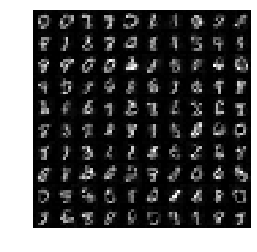

num_img: 903040    |  lod_in: 1.99   |  D real loss: 0.923695   |  D fake loss: 0.345327   |  Projection loss: 388.931396


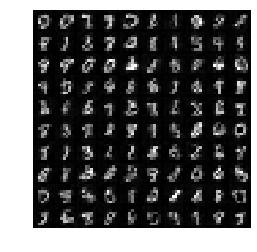

num_img: 953088    |  lod_in: 1.82   |  D real loss: 0.322356   |  D fake loss: 0.946113   |  Projection loss: 352.811340


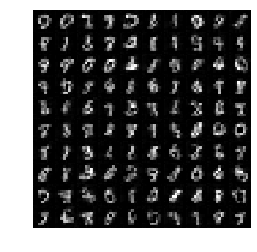

num_img: 1003136    |  lod_in: 1.66   |  D real loss: 0.769174   |  D fake loss: 0.436021   |  Projection loss: 427.248352


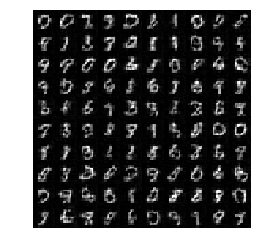

num_img: 1053184    |  lod_in: 1.49   |  D real loss: 0.342180   |  D fake loss: 1.004889   |  Projection loss: 307.630615


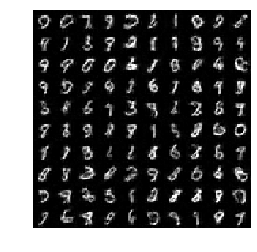

num_img: 1103232    |  lod_in: 1.32   |  D real loss: 0.300855   |  D fake loss: 1.292224   |  Projection loss: 244.958649


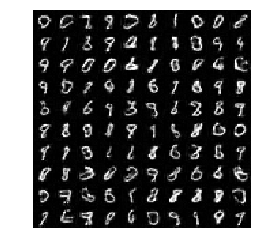

num_img: 1153280    |  lod_in: 1.16   |  D real loss: 0.281887   |  D fake loss: 1.362792   |  Projection loss: 416.940643


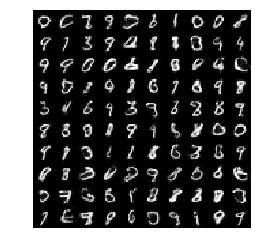

num_img: 1203328    |  lod_in: 1.00   |  D real loss: 0.266034   |  D fake loss: 1.497262   |  Projection loss: 1596.425537


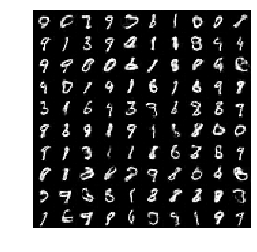

num_img: 1253376    |  lod_in: 1.00   |  D real loss: 0.697235   |  D fake loss: 0.615923   |  Projection loss: 540.771851


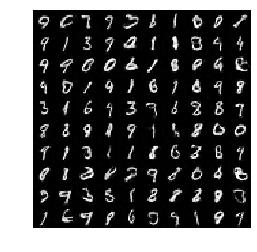

num_img: 1303424    |  lod_in: 1.00   |  D real loss: 0.245410   |  D fake loss: 1.272660   |  Projection loss: 550.268250


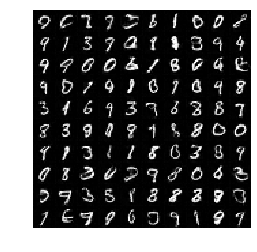

num_img: 1353472    |  lod_in: 1.00   |  D real loss: 0.357328   |  D fake loss: 1.094093   |  Projection loss: 655.723633


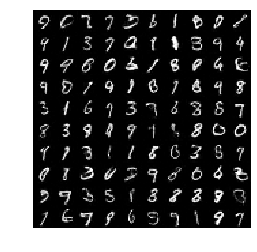

num_img: 1403520    |  lod_in: 1.00   |  D real loss: 0.307413   |  D fake loss: 1.104104   |  Projection loss: 233.885590


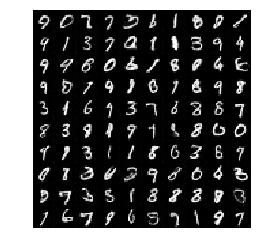

num_img: 1453568    |  lod_in: 1.00   |  D real loss: 1.193819   |  D fake loss: 0.287236   |  Projection loss: 1872.549561


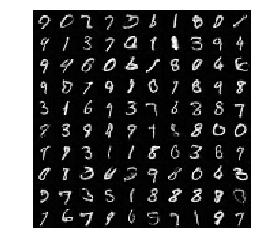

num_img: 1503616    |  lod_in: 0.99   |  D real loss: 0.288426   |  D fake loss: 1.254538   |  Projection loss: 173.517899


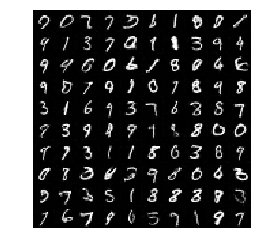

num_img: 1553664    |  lod_in: 0.82   |  D real loss: 0.275976   |  D fake loss: 1.143021   |  Projection loss: 1152.857666


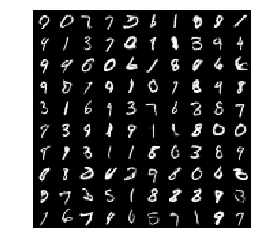

num_img: 1603712    |  lod_in: 0.65   |  D real loss: 0.692472   |  D fake loss: 0.559537   |  Projection loss: 507.782654


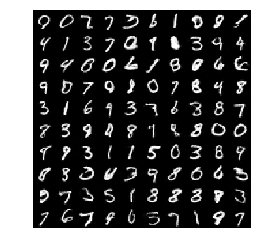

num_img: 1653760    |  lod_in: 0.49   |  D real loss: 0.571413   |  D fake loss: 0.684250   |  Projection loss: 239.206329


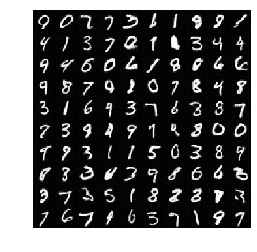

num_img: 1703808    |  lod_in: 0.32   |  D real loss: 0.855518   |  D fake loss: 0.586957   |  Projection loss: 948.120605


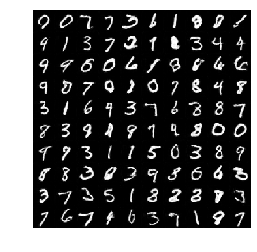

num_img: 1753856    |  lod_in: 0.15   |  D real loss: 0.312587   |  D fake loss: 1.390485   |  Projection loss: 528.239624


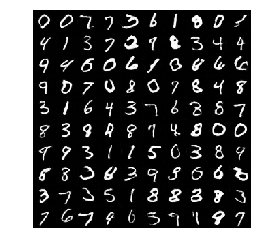

num_img: 1803904    |  lod_in: 0.00   |  D real loss: 0.730243   |  D fake loss: 0.455689   |  Projection loss: 538.143860


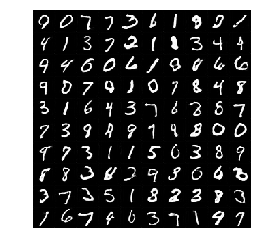

num_img: 1853952    |  lod_in: 0.00   |  D real loss: 0.728128   |  D fake loss: 0.311333   |  Projection loss: 345.011230


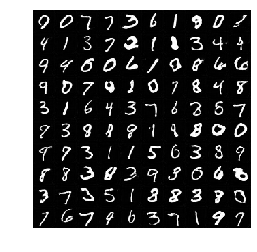

num_img: 1904000    |  lod_in: 0.00   |  D real loss: 0.294160   |  D fake loss: 0.313701   |  Projection loss: 439.250397


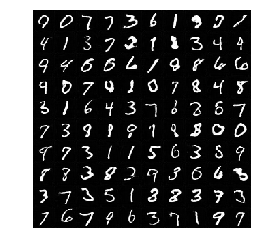

num_img: 1954048    |  lod_in: 0.00   |  D real loss: 0.253923   |  D fake loss: 0.371456   |  Projection loss: 381.471313


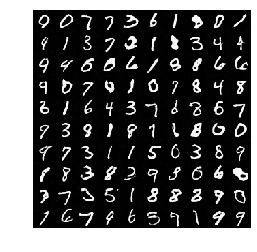

num_img: 2004096    |  lod_in: 0.00   |  D real loss: 0.380339   |  D fake loss: 0.059885   |  Projection loss: 597.999268


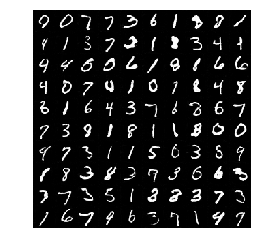

num_img: 2054144    |  lod_in: 0.00   |  D real loss: 0.812946   |  D fake loss: 0.074179   |  Projection loss: 468.849152


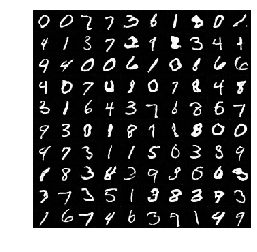

num_img: 2104192    |  lod_in: 0.00   |  D real loss: 0.512372   |  D fake loss: 0.152423   |  Projection loss: 454.860779


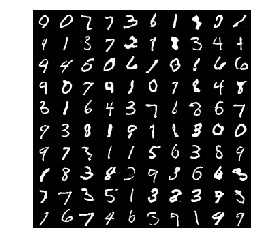

num_img: 2154240    |  lod_in: 0.00   |  D real loss: 0.505172   |  D fake loss: 0.074107   |  Projection loss: 554.510254


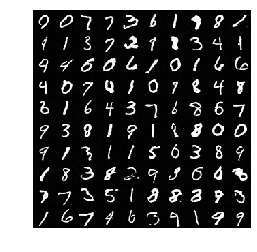

num_img: 2204288    |  lod_in: 0.00   |  D real loss: 0.208540   |  D fake loss: 0.079495   |  Projection loss: 880.687866


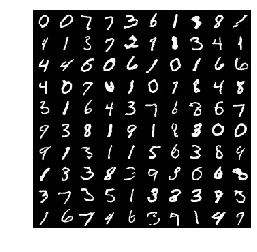

num_img: 2254336    |  lod_in: 0.00   |  D real loss: 0.490332   |  D fake loss: 0.038192   |  Projection loss: 807.700195


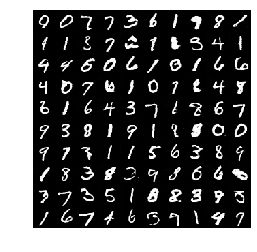

num_img: 2304384    |  lod_in: 0.00   |  D real loss: 0.625289   |  D fake loss: 0.032259   |  Projection loss: 611.937500


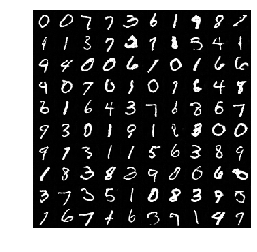

num_img: 2354432    |  lod_in: 0.00   |  D real loss: 0.547114   |  D fake loss: 0.087780   |  Projection loss: 734.538086


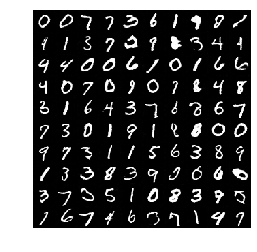

In [11]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_nimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='KL') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if num_img >= tick_nimg + 50 * 1000:
            tick_nimg = num_img
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()

# Logd divergence:

num_img: 50176    |  lod_in: 3.00   |  D real loss: 0.703626   |  D fake loss: 0.542248   |  Projection loss: 7.965652


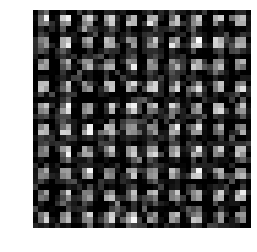

num_img: 100352    |  lod_in: 3.00   |  D real loss: 0.579811   |  D fake loss: 0.739454   |  Projection loss: 30.395081


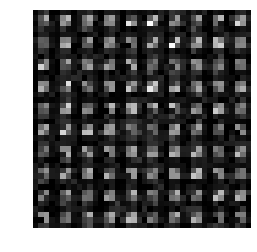

num_img: 150528    |  lod_in: 3.00   |  D real loss: 0.520500   |  D fake loss: 0.855128   |  Projection loss: 158.101761


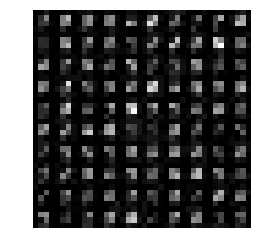

num_img: 200704    |  lod_in: 3.00   |  D real loss: 0.587123   |  D fake loss: 0.768810   |  Projection loss: 128.342072


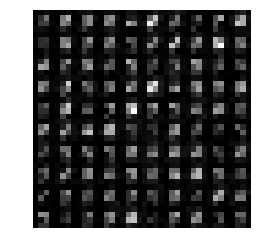

num_img: 250880    |  lod_in: 3.00   |  D real loss: 0.609773   |  D fake loss: 0.747343   |  Projection loss: 154.208740


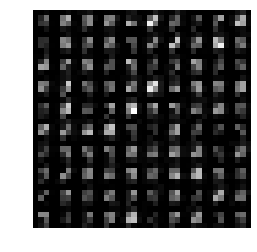

num_img: 301056    |  lod_in: 3.00   |  D real loss: 0.602078   |  D fake loss: 0.755433   |  Projection loss: 111.292023


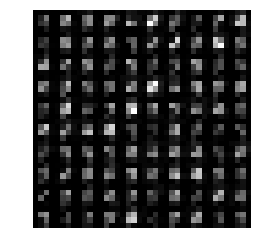

num_img: 351232    |  lod_in: 2.83   |  D real loss: 0.610881   |  D fake loss: 0.735440   |  Projection loss: 222.684280


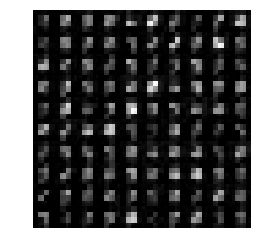

num_img: 401408    |  lod_in: 2.66   |  D real loss: 0.557077   |  D fake loss: 0.752845   |  Projection loss: 46.282730


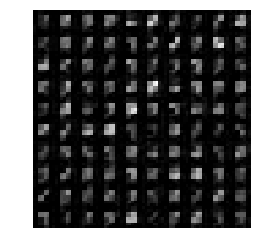

num_img: 451584    |  lod_in: 2.49   |  D real loss: 0.572376   |  D fake loss: 0.723431   |  Projection loss: 102.063866


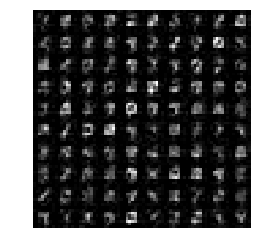

num_img: 501760    |  lod_in: 2.33   |  D real loss: 0.801453   |  D fake loss: 0.457349   |  Projection loss: 343.465363


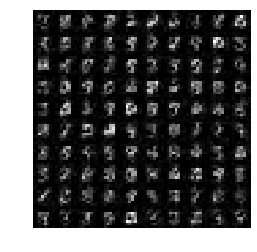

num_img: 551936    |  lod_in: 2.16   |  D real loss: 0.397923   |  D fake loss: 0.762438   |  Projection loss: 793.427124


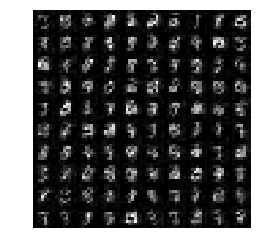

num_img: 602112    |  lod_in: 2.00   |  D real loss: 0.337088   |  D fake loss: 0.719202   |  Projection loss: 2206.228027


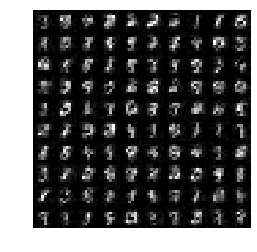

num_img: 652288    |  lod_in: 2.00   |  D real loss: 0.421260   |  D fake loss: 0.501070   |  Projection loss: 5409.519531


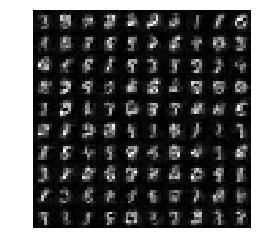

num_img: 702464    |  lod_in: 2.00   |  D real loss: 0.289245   |  D fake loss: 0.806480   |  Projection loss: 509.941040


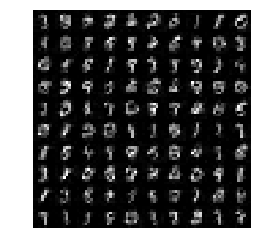

num_img: 752640    |  lod_in: 2.00   |  D real loss: 0.407998   |  D fake loss: 0.705935   |  Projection loss: 531.546265


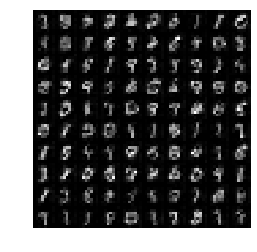

num_img: 802816    |  lod_in: 2.00   |  D real loss: 0.257449   |  D fake loss: 0.994605   |  Projection loss: 394.675049


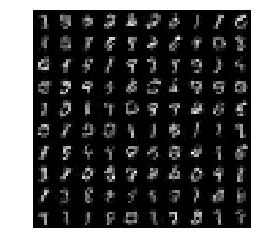

num_img: 852992    |  lod_in: 2.00   |  D real loss: 0.444827   |  D fake loss: 0.653320   |  Projection loss: 828.756592


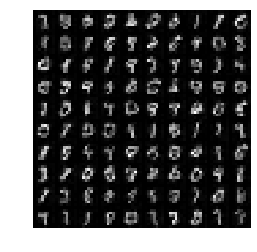

num_img: 903040    |  lod_in: 1.99   |  D real loss: 0.368347   |  D fake loss: 0.780715   |  Projection loss: 192.493896


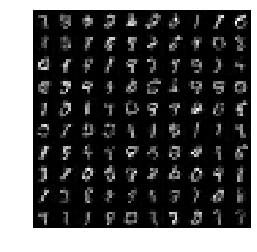

num_img: 953088    |  lod_in: 1.82   |  D real loss: 0.739712   |  D fake loss: 0.418965   |  Projection loss: 734.055176


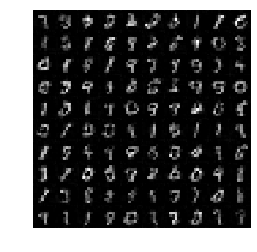

num_img: 1003136    |  lod_in: 1.66   |  D real loss: 0.475118   |  D fake loss: 0.656941   |  Projection loss: 512.785034


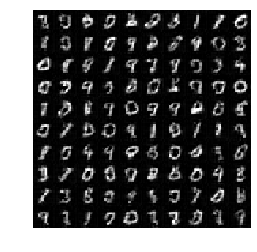

num_img: 1053184    |  lod_in: 1.49   |  D real loss: 0.362650   |  D fake loss: 0.810927   |  Projection loss: 623.000732


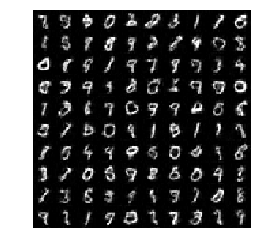

num_img: 1103232    |  lod_in: 1.32   |  D real loss: 0.671138   |  D fake loss: 0.535552   |  Projection loss: 779.074463


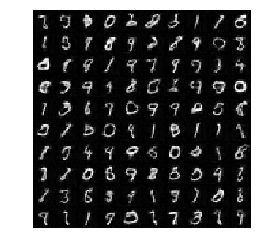

num_img: 1153280    |  lod_in: 1.16   |  D real loss: 0.772808   |  D fake loss: 0.470301   |  Projection loss: 422.841431


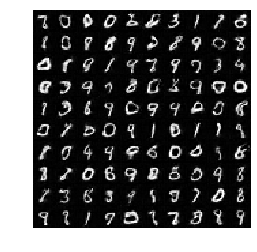

num_img: 1203328    |  lod_in: 1.00   |  D real loss: 0.675471   |  D fake loss: 0.541888   |  Projection loss: 427.988281


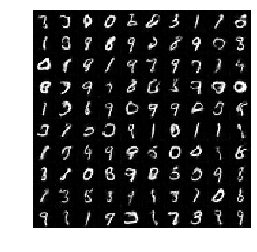

num_img: 1253376    |  lod_in: 1.00   |  D real loss: 0.249264   |  D fake loss: 1.035605   |  Projection loss: 202.493408


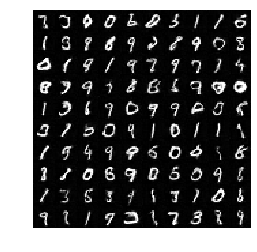

num_img: 1303424    |  lod_in: 1.00   |  D real loss: 0.345819   |  D fake loss: 0.946214   |  Projection loss: 747.860413


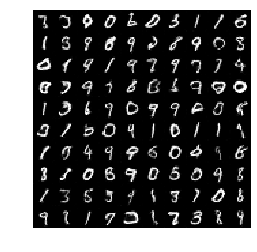

num_img: 1353472    |  lod_in: 1.00   |  D real loss: 0.405814   |  D fake loss: 0.764920   |  Projection loss: 1258.231201


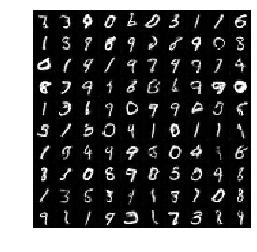

num_img: 1403520    |  lod_in: 1.00   |  D real loss: 0.743294   |  D fake loss: 0.420614   |  Projection loss: 972.986938


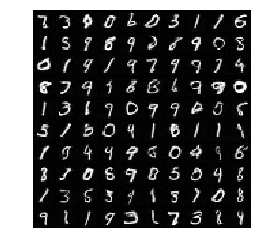

num_img: 1453568    |  lod_in: 1.00   |  D real loss: 0.697355   |  D fake loss: 0.614538   |  Projection loss: 1407.899292


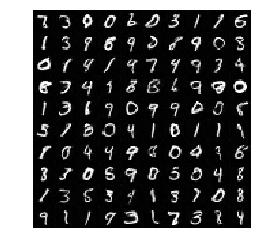

num_img: 1503616    |  lod_in: 0.99   |  D real loss: 0.636996   |  D fake loss: 0.687531   |  Projection loss: 217.362289


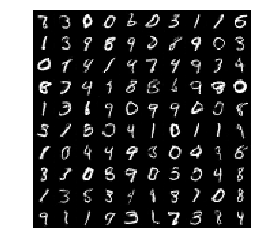

num_img: 1553664    |  lod_in: 0.82   |  D real loss: 0.268155   |  D fake loss: 1.106363   |  Projection loss: 110.795898


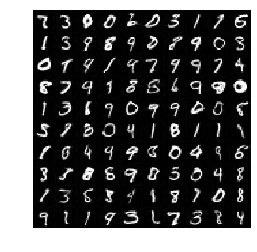

num_img: 1603712    |  lod_in: 0.65   |  D real loss: 0.841554   |  D fake loss: 0.458310   |  Projection loss: 418.235352


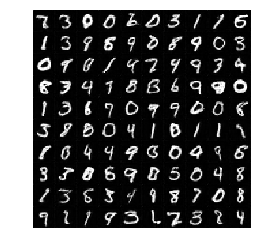

num_img: 1653760    |  lod_in: 0.49   |  D real loss: 0.647983   |  D fake loss: 0.609736   |  Projection loss: 209.113052


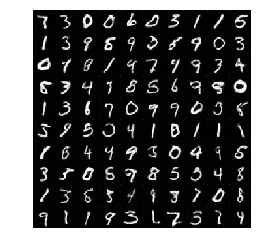

num_img: 1703808    |  lod_in: 0.32   |  D real loss: 0.489783   |  D fake loss: 0.839756   |  Projection loss: 1012.267883


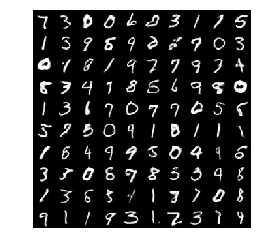

num_img: 1753856    |  lod_in: 0.15   |  D real loss: 0.381835   |  D fake loss: 0.989607   |  Projection loss: 129.243500


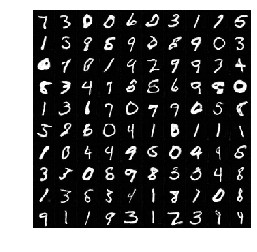

num_img: 1803904    |  lod_in: 0.00   |  D real loss: 0.261996   |  D fake loss: 1.276528   |  Projection loss: 99.334908


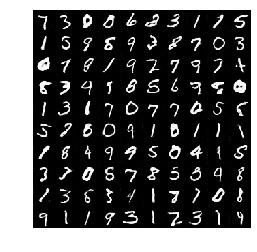

num_img: 1853952    |  lod_in: 0.00   |  D real loss: 0.848223   |  D fake loss: 0.405072   |  Projection loss: 309.564087


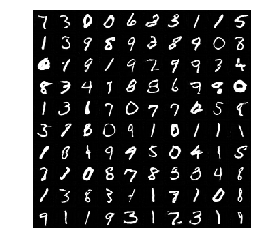

num_img: 1904000    |  lod_in: 0.00   |  D real loss: 0.286262   |  D fake loss: 1.545451   |  Projection loss: 174.565094


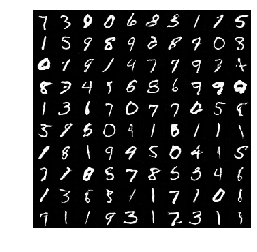

num_img: 1954048    |  lod_in: 0.00   |  D real loss: 0.991884   |  D fake loss: 0.290471   |  Projection loss: 881.212891


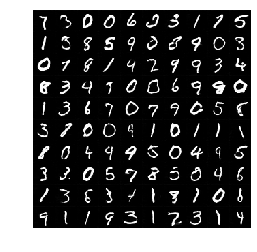

num_img: 2004096    |  lod_in: 0.00   |  D real loss: 0.346330   |  D fake loss: 1.014715   |  Projection loss: 352.601440


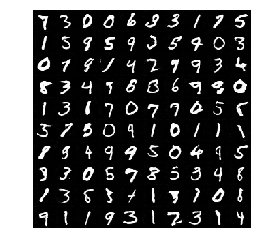

num_img: 2054144    |  lod_in: 0.00   |  D real loss: 0.158117   |  D fake loss: 1.603033   |  Projection loss: 206.924194


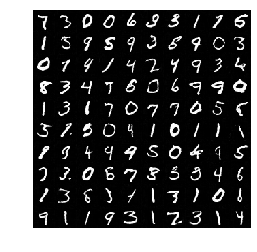

num_img: 2104192    |  lod_in: 0.00   |  D real loss: 0.761112   |  D fake loss: 0.277722   |  Projection loss: 744.541687


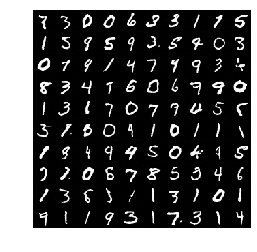

num_img: 2154240    |  lod_in: 0.00   |  D real loss: 0.623493   |  D fake loss: 0.257882   |  Projection loss: 859.293396


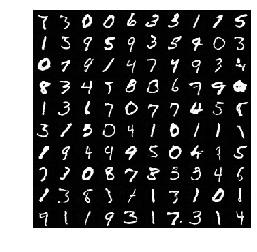

num_img: 2204288    |  lod_in: 0.00   |  D real loss: 0.458322   |  D fake loss: 0.653066   |  Projection loss: 360.621552


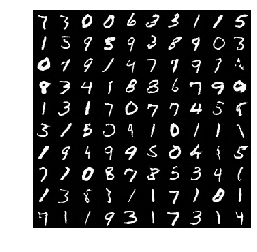

num_img: 2254336    |  lod_in: 0.00   |  D real loss: 0.300808   |  D fake loss: 1.302358   |  Projection loss: 320.899658


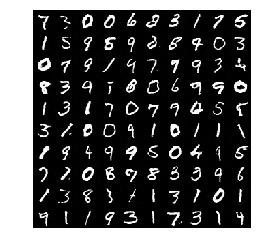

num_img: 2304384    |  lod_in: 0.00   |  D real loss: 0.323319   |  D fake loss: 0.506288   |  Projection loss: 457.588623


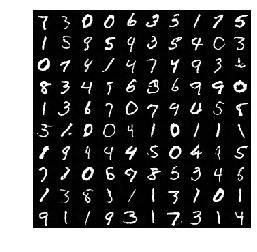

num_img: 2354432    |  lod_in: 0.00   |  D real loss: 0.584482   |  D fake loss: 0.173600   |  Projection loss: 569.050110


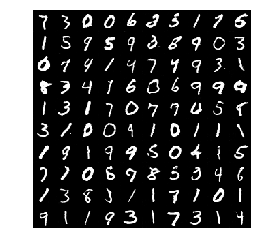

In [12]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_nimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='Logd') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if num_img >= tick_nimg + 50 * 1000:
            tick_nimg = num_img
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()

# JS divergence:

num_img: 50176    |  lod_in: 3.00   |  D real loss: 0.531678   |  D fake loss: 0.719900   |  Projection loss: 241.116974


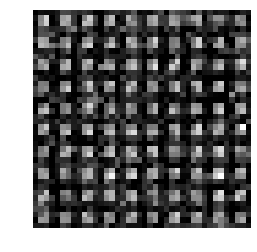

num_img: 100352    |  lod_in: 3.00   |  D real loss: 0.520274   |  D fake loss: 0.811994   |  Projection loss: 196.434692


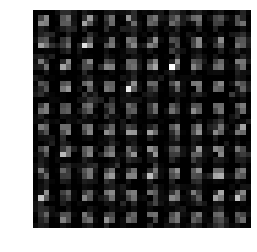

num_img: 150528    |  lod_in: 3.00   |  D real loss: 0.555714   |  D fake loss: 0.803875   |  Projection loss: 198.146301


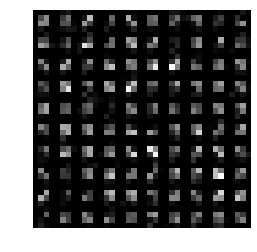

num_img: 200704    |  lod_in: 3.00   |  D real loss: 0.588198   |  D fake loss: 0.771573   |  Projection loss: 82.304337


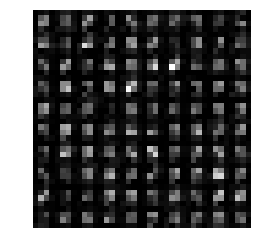

num_img: 250880    |  lod_in: 3.00   |  D real loss: 0.610074   |  D fake loss: 0.742872   |  Projection loss: 67.279160


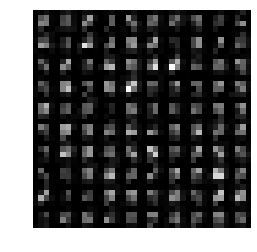

num_img: 301056    |  lod_in: 3.00   |  D real loss: 0.599363   |  D fake loss: 0.760090   |  Projection loss: 280.119965


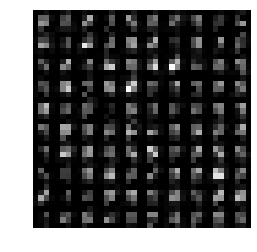

num_img: 351232    |  lod_in: 2.83   |  D real loss: 0.676596   |  D fake loss: 0.665635   |  Projection loss: 83.916023


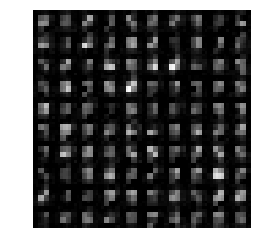

num_img: 401408    |  lod_in: 2.66   |  D real loss: 0.741276   |  D fake loss: 0.571280   |  Projection loss: 628.471741


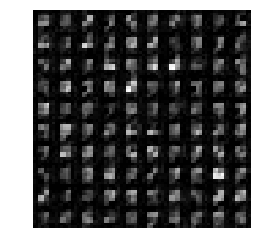

num_img: 451584    |  lod_in: 2.49   |  D real loss: 0.730237   |  D fake loss: 0.557720   |  Projection loss: 1374.053589


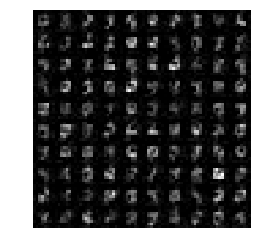

num_img: 501760    |  lod_in: 2.33   |  D real loss: 0.695136   |  D fake loss: 0.562596   |  Projection loss: 1031.182861


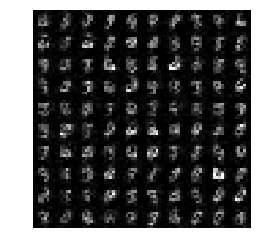

num_img: 551936    |  lod_in: 2.16   |  D real loss: 0.616416   |  D fake loss: 0.506847   |  Projection loss: 6149.516113


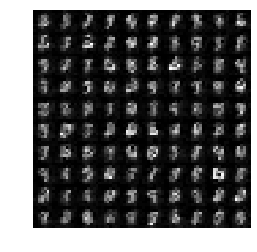

num_img: 602112    |  lod_in: 2.00   |  D real loss: 0.641187   |  D fake loss: 0.452575   |  Projection loss: 516.676270


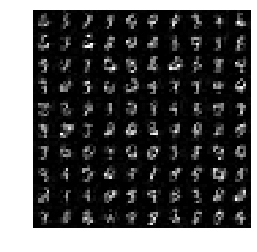

num_img: 652288    |  lod_in: 2.00   |  D real loss: 0.245900   |  D fake loss: 1.085094   |  Projection loss: 1537.894531


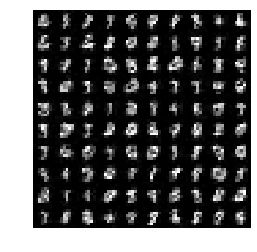

num_img: 702464    |  lod_in: 2.00   |  D real loss: 0.615710   |  D fake loss: 0.373958   |  Projection loss: 6262.562012


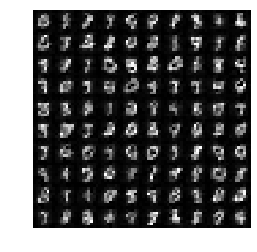

num_img: 752640    |  lod_in: 2.00   |  D real loss: 0.400540   |  D fake loss: 0.732581   |  Projection loss: 1169.474609


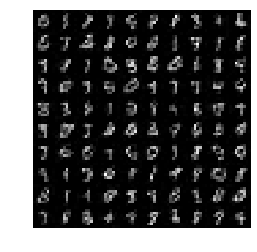

num_img: 802816    |  lod_in: 2.00   |  D real loss: 0.630157   |  D fake loss: 0.418029   |  Projection loss: 1254.665039


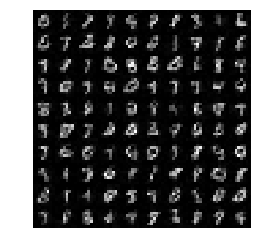

num_img: 852992    |  lod_in: 2.00   |  D real loss: 0.851790   |  D fake loss: 0.315335   |  Projection loss: 389.345001


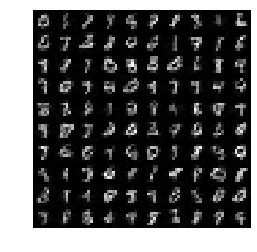

num_img: 903040    |  lod_in: 1.99   |  D real loss: 0.805933   |  D fake loss: 0.342298   |  Projection loss: 169.620544


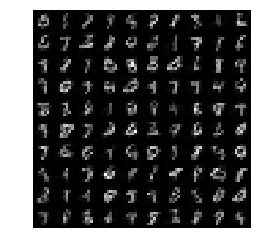

num_img: 953088    |  lod_in: 1.82   |  D real loss: 0.810304   |  D fake loss: 0.375192   |  Projection loss: 623.058594


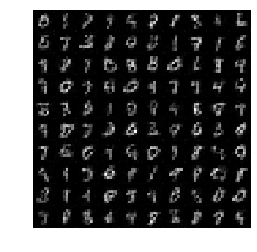

num_img: 1003136    |  lod_in: 1.66   |  D real loss: 0.744534   |  D fake loss: 0.443557   |  Projection loss: 159.251312


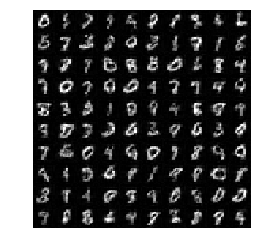

num_img: 1053184    |  lod_in: 1.49   |  D real loss: 0.570696   |  D fake loss: 0.605910   |  Projection loss: 382.711884


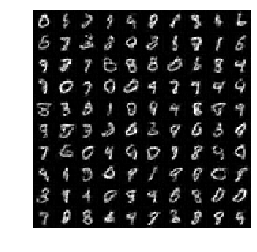

num_img: 1103232    |  lod_in: 1.32   |  D real loss: 0.293616   |  D fake loss: 1.059574   |  Projection loss: 331.465637


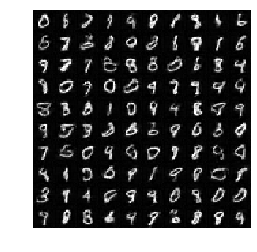

num_img: 1153280    |  lod_in: 1.16   |  D real loss: 0.738366   |  D fake loss: 0.429396   |  Projection loss: 644.871826


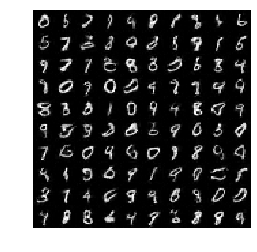

num_img: 1203328    |  lod_in: 1.00   |  D real loss: 0.568485   |  D fake loss: 0.433039   |  Projection loss: 599.275818


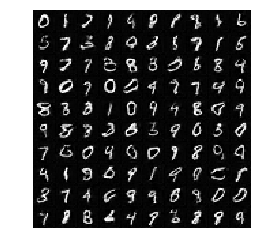

num_img: 1253376    |  lod_in: 1.00   |  D real loss: 0.232006   |  D fake loss: 1.185221   |  Projection loss: 1125.336304


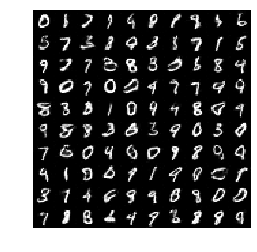

num_img: 1303424    |  lod_in: 1.00   |  D real loss: 0.940335   |  D fake loss: 0.177093   |  Projection loss: 292.904419


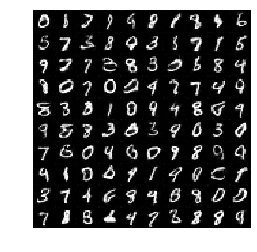

num_img: 1353472    |  lod_in: 1.00   |  D real loss: 0.243832   |  D fake loss: 1.248139   |  Projection loss: 401.520935


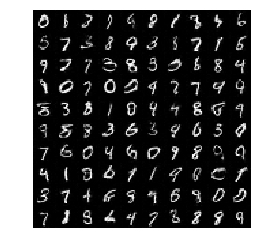

num_img: 1403520    |  lod_in: 1.00   |  D real loss: 0.783769   |  D fake loss: 0.225560   |  Projection loss: 262.463867


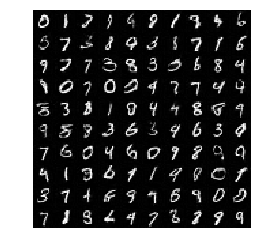

num_img: 1453568    |  lod_in: 1.00   |  D real loss: 1.162541   |  D fake loss: 0.139430   |  Projection loss: 115.347427


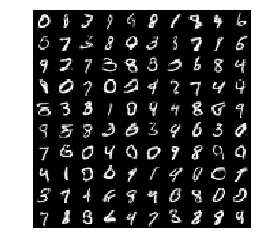

num_img: 1503616    |  lod_in: 0.99   |  D real loss: 0.654797   |  D fake loss: 0.422915   |  Projection loss: 95.563789


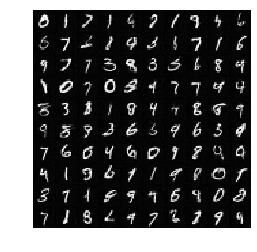

num_img: 1553664    |  lod_in: 0.82   |  D real loss: 0.466631   |  D fake loss: 0.631303   |  Projection loss: 273.281342


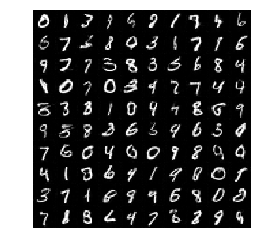

num_img: 1603712    |  lod_in: 0.65   |  D real loss: 0.424926   |  D fake loss: 0.710468   |  Projection loss: 61.620129


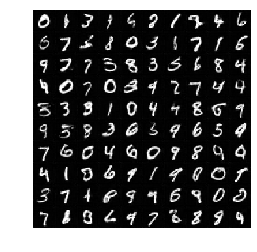

num_img: 1653760    |  lod_in: 0.49   |  D real loss: 0.923236   |  D fake loss: 0.267210   |  Projection loss: 171.963043


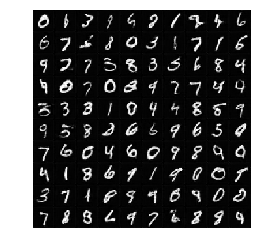

num_img: 1703808    |  lod_in: 0.32   |  D real loss: 0.715619   |  D fake loss: 0.469928   |  Projection loss: 98.767593


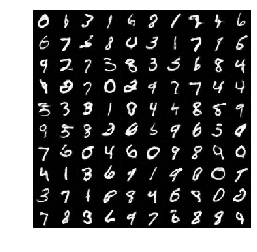

num_img: 1753856    |  lod_in: 0.15   |  D real loss: 0.354447   |  D fake loss: 1.280707   |  Projection loss: 380.785461


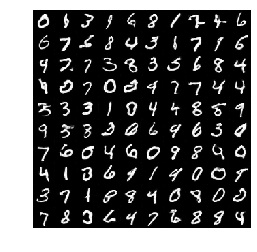

num_img: 1803904    |  lod_in: 0.00   |  D real loss: 0.311971   |  D fake loss: 0.932614   |  Projection loss: 380.229858


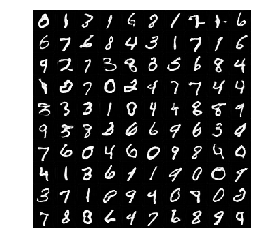

num_img: 1853952    |  lod_in: 0.00   |  D real loss: 0.990003   |  D fake loss: 0.249391   |  Projection loss: 52.689957


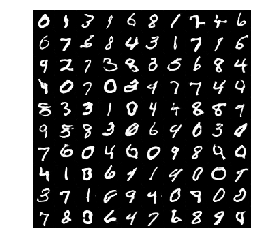

num_img: 1904000    |  lod_in: 0.00   |  D real loss: 0.221789   |  D fake loss: 0.181321   |  Projection loss: 336.694458


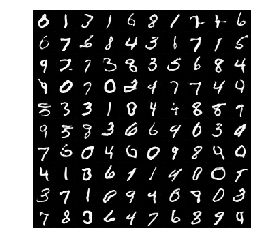

num_img: 1954048    |  lod_in: 0.00   |  D real loss: 0.439313   |  D fake loss: 0.265448   |  Projection loss: 137.780975


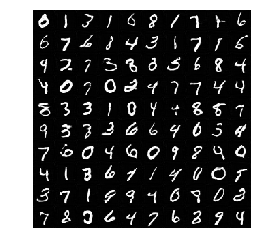

num_img: 2004096    |  lod_in: 0.00   |  D real loss: 0.888250   |  D fake loss: 0.233048   |  Projection loss: 245.714600


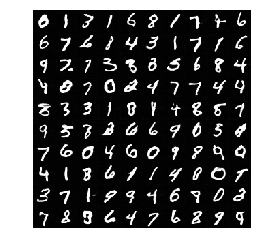

num_img: 2054144    |  lod_in: 0.00   |  D real loss: 0.745446   |  D fake loss: 0.183394   |  Projection loss: 90.676941


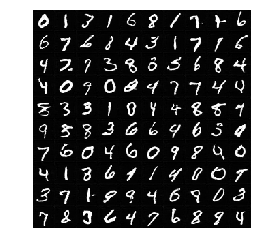

num_img: 2104192    |  lod_in: 0.00   |  D real loss: 0.095516   |  D fake loss: 0.021056   |  Projection loss: 682.659058


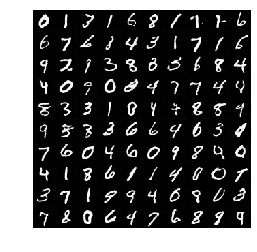

num_img: 2154240    |  lod_in: 0.00   |  D real loss: 0.671820   |  D fake loss: 0.142262   |  Projection loss: 84.659081


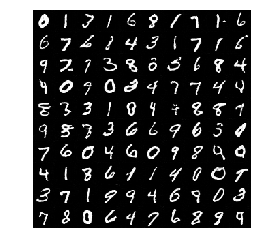

num_img: 2204288    |  lod_in: 0.00   |  D real loss: 0.593765   |  D fake loss: 0.102973   |  Projection loss: 107.378555


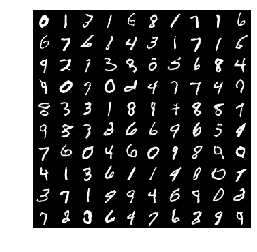

num_img: 2254336    |  lod_in: 0.00   |  D real loss: 0.725582   |  D fake loss: 0.131136   |  Projection loss: 48.017864


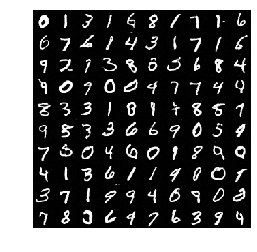

num_img: 2304384    |  lod_in: 0.00   |  D real loss: 0.114696   |  D fake loss: 0.016734   |  Projection loss: 1344.556641


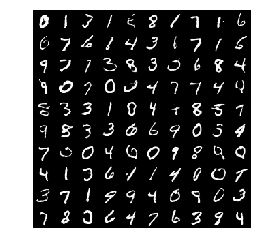

num_img: 2354432    |  lod_in: 0.00   |  D real loss: 0.469514   |  D fake loss: 0.115115   |  Projection loss: 227.494949


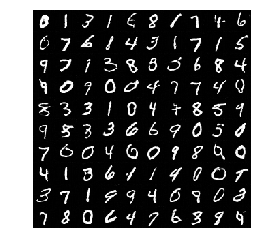

In [11]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_nimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='JS') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if num_img >= tick_nimg + 50 * 1000:
            tick_nimg = num_img
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()

# Jef divergence:

num_img: 50176    |  lod_in: 3.00   |  D real loss: 0.574412   |  D fake loss: 0.696981   |  Projection loss: 374.983459


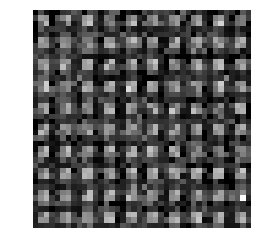

num_img: 100352    |  lod_in: 3.00   |  D real loss: 0.577335   |  D fake loss: 0.780403   |  Projection loss: 243.551208


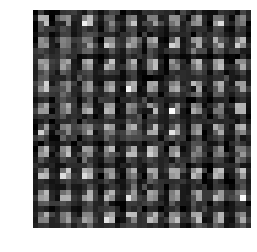

num_img: 150528    |  lod_in: 3.00   |  D real loss: 0.505683   |  D fake loss: 0.890970   |  Projection loss: 249.882828


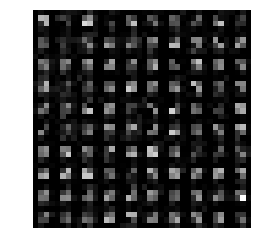

num_img: 200704    |  lod_in: 3.00   |  D real loss: 0.743377   |  D fake loss: 0.631277   |  Projection loss: 31.290779


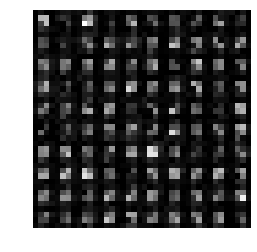

num_img: 250880    |  lod_in: 3.00   |  D real loss: 0.788700   |  D fake loss: 0.579879   |  Projection loss: 207.093567


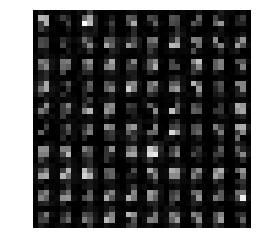

num_img: 301056    |  lod_in: 3.00   |  D real loss: 0.771437   |  D fake loss: 0.593623   |  Projection loss: 234.466125


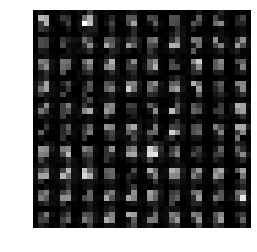

num_img: 351232    |  lod_in: 2.83   |  D real loss: 0.754043   |  D fake loss: 0.607170   |  Projection loss: 806.777222


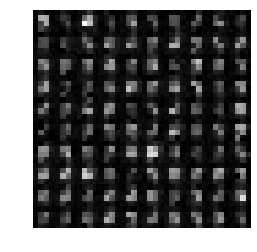

num_img: 401408    |  lod_in: 2.66   |  D real loss: 0.710238   |  D fake loss: 0.582443   |  Projection loss: 3945.026855


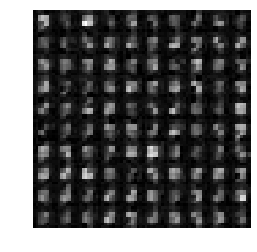

num_img: 451584    |  lod_in: 2.49   |  D real loss: 0.772965   |  D fake loss: 0.540593   |  Projection loss: 1185.623657


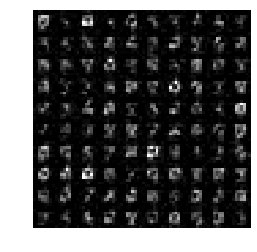

num_img: 501760    |  lod_in: 2.33   |  D real loss: 0.467133   |  D fake loss: 0.886999   |  Projection loss: 3332.535645


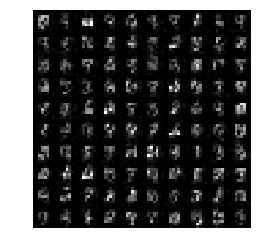

num_img: 551936    |  lod_in: 2.16   |  D real loss: 0.765402   |  D fake loss: 0.472415   |  Projection loss: 1478.594482


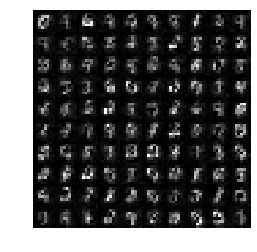

num_img: 602112    |  lod_in: 2.00   |  D real loss: 0.314563   |  D fake loss: 1.063870   |  Projection loss: 1074.600586


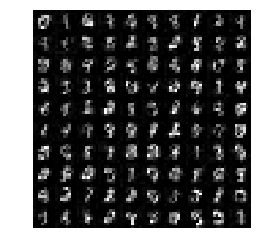

num_img: 652288    |  lod_in: 2.00   |  D real loss: 0.732600   |  D fake loss: 0.441586   |  Projection loss: 4849.809082


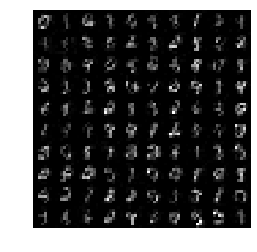

num_img: 702464    |  lod_in: 2.00   |  D real loss: 0.331448   |  D fake loss: 1.095622   |  Projection loss: 554.710999


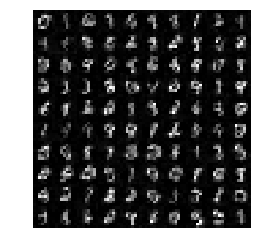

num_img: 752640    |  lod_in: 2.00   |  D real loss: 0.428030   |  D fake loss: 0.928254   |  Projection loss: 661.622681


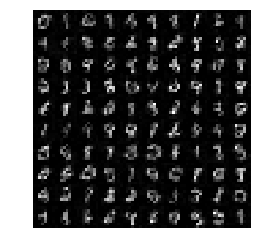

num_img: 802816    |  lod_in: 2.00   |  D real loss: 0.477260   |  D fake loss: 0.775169   |  Projection loss: 472.231995


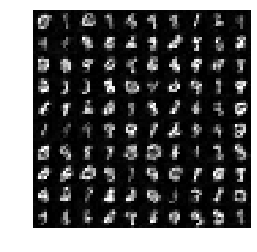

num_img: 852992    |  lod_in: 2.00   |  D real loss: 0.583067   |  D fake loss: 0.621471   |  Projection loss: 5308.994141


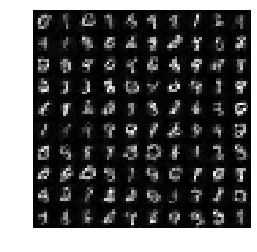

num_img: 903040    |  lod_in: 1.99   |  D real loss: 0.322032   |  D fake loss: 1.218369   |  Projection loss: 929.075195


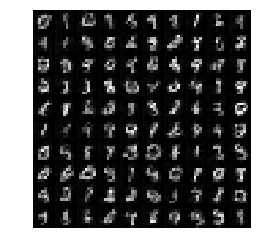

num_img: 953088    |  lod_in: 1.82   |  D real loss: 0.362450   |  D fake loss: 1.041022   |  Projection loss: 279.215759


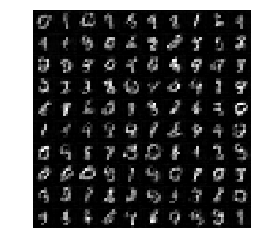

num_img: 1003136    |  lod_in: 1.66   |  D real loss: 0.807111   |  D fake loss: 0.533634   |  Projection loss: 150.137741


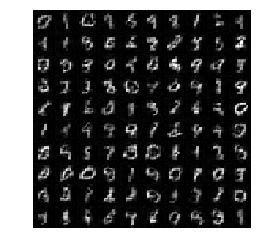

num_img: 1053184    |  lod_in: 1.49   |  D real loss: 0.788578   |  D fake loss: 0.515558   |  Projection loss: 574.273560


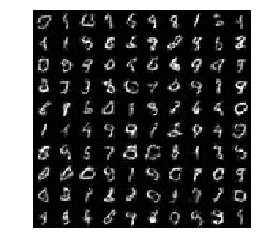

num_img: 1103232    |  lod_in: 1.32   |  D real loss: 0.884153   |  D fake loss: 0.438401   |  Projection loss: 1677.250000


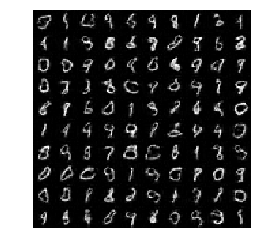

num_img: 1153280    |  lod_in: 1.16   |  D real loss: 0.621981   |  D fake loss: 0.822031   |  Projection loss: 286.249084


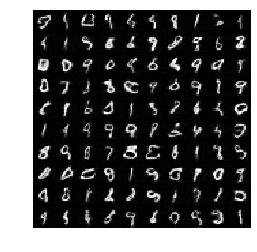

num_img: 1203328    |  lod_in: 1.00   |  D real loss: 0.361422   |  D fake loss: 1.426901   |  Projection loss: 2427.311035


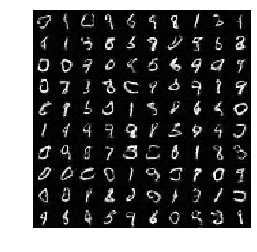

num_img: 1253376    |  lod_in: 1.00   |  D real loss: 0.474532   |  D fake loss: 0.942254   |  Projection loss: 1553.021973


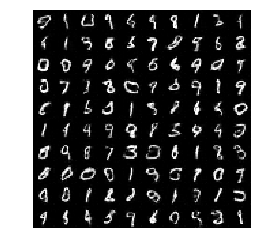

num_img: 1303424    |  lod_in: 1.00   |  D real loss: 0.536391   |  D fake loss: 0.840709   |  Projection loss: 433.345093


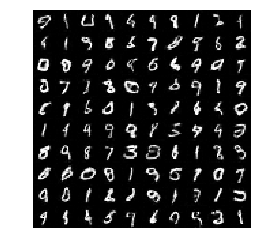

num_img: 1353472    |  lod_in: 1.00   |  D real loss: 0.326893   |  D fake loss: 0.965076   |  Projection loss: 1227.227295


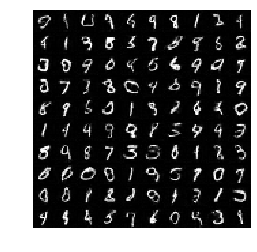

num_img: 1403520    |  lod_in: 1.00   |  D real loss: 0.526431   |  D fake loss: 0.714846   |  Projection loss: 438.386658


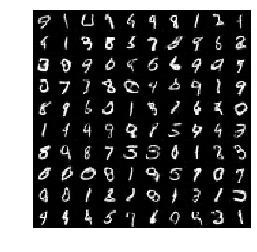

num_img: 1453568    |  lod_in: 1.00   |  D real loss: 0.819292   |  D fake loss: 0.542987   |  Projection loss: 724.752869


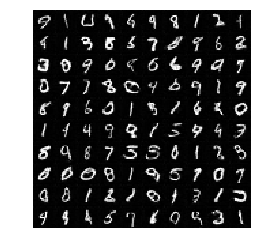

num_img: 1503616    |  lod_in: 0.99   |  D real loss: 0.574582   |  D fake loss: 0.575475   |  Projection loss: 238.325867


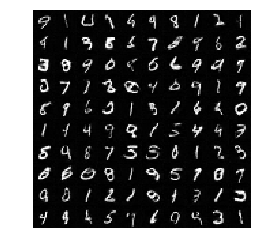

num_img: 1553664    |  lod_in: 0.82   |  D real loss: 0.340502   |  D fake loss: 0.860074   |  Projection loss: 356.184753


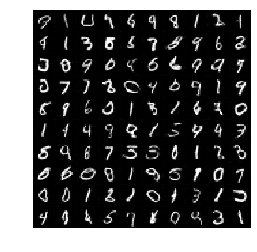

num_img: 1603712    |  lod_in: 0.65   |  D real loss: 0.244391   |  D fake loss: 0.907014   |  Projection loss: 864.243530


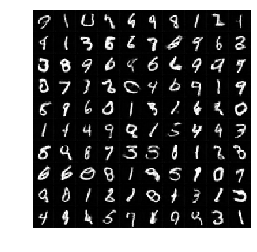

num_img: 1653760    |  lod_in: 0.49   |  D real loss: 0.568985   |  D fake loss: 0.715535   |  Projection loss: 197.664917


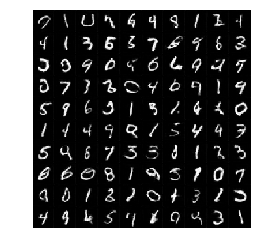

num_img: 1703808    |  lod_in: 0.32   |  D real loss: 0.611315   |  D fake loss: 0.841019   |  Projection loss: 438.624512


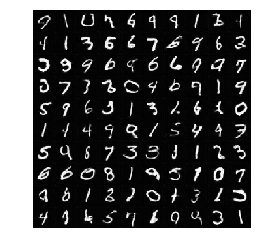

num_img: 1753856    |  lod_in: 0.15   |  D real loss: 0.385011   |  D fake loss: 0.701941   |  Projection loss: 987.129822


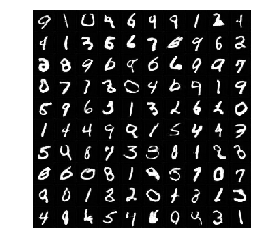

num_img: 1803904    |  lod_in: 0.00   |  D real loss: 1.096176   |  D fake loss: 0.264885   |  Projection loss: 461.690125


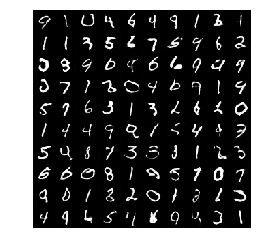

num_img: 1853952    |  lod_in: 0.00   |  D real loss: 0.263782   |  D fake loss: 0.027047   |  Projection loss: 1403.803223


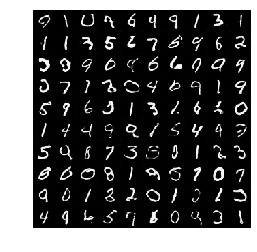

num_img: 1904000    |  lod_in: 0.00   |  D real loss: 0.731350   |  D fake loss: 0.107233   |  Projection loss: 653.128662


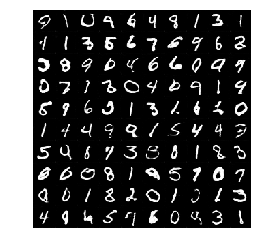

num_img: 1954048    |  lod_in: 0.00   |  D real loss: 0.216828   |  D fake loss: 0.005191   |  Projection loss: 1913.005859


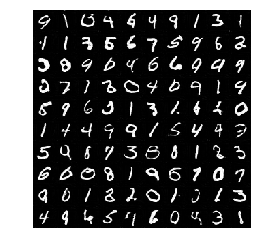

num_img: 2004096    |  lod_in: 0.00   |  D real loss: 0.640723   |  D fake loss: 0.033280   |  Projection loss: 592.894714


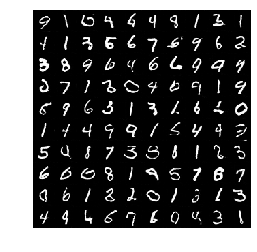

num_img: 2054144    |  lod_in: 0.00   |  D real loss: 0.646594   |  D fake loss: 0.000758   |  Projection loss: 794.406433


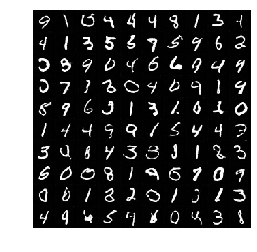

num_img: 2104192    |  lod_in: 0.00   |  D real loss: 0.808283   |  D fake loss: 0.001545   |  Projection loss: 734.711548


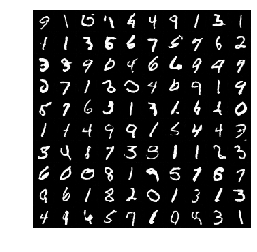

In [ ]:
with tf.Session() as sess:

    iterators = [data_tool.data_iterator('mnist', lod_in=lod, batch_size=minibatch_dict[2**(resolution_log2-lod)], resolution_log2=resolution_log2) for lod in range(int(np.log2(resolution/init_resolution))+1)]
    sess.run(tf.global_variables_initializer())
    num_img = 0
    tick_nimg = 0
    z_fixed = np.random.randn(num_row*num_line, z_dim)
    prev_lod = -1.0

    while num_img <= total_nimg:
        cur_lod = lod(num_img)
        # reset Adam optimizers states when increasing resolution:
        if np.floor(cur_lod) != np.floor(prev_lod) or np.ceil(cur_lod) != np.ceil(prev_lod):
            sess.run([reset_optimizer_d, reset_optimizer_g])
        prev_lod = cur_lod
        # get mini-batch size:
        batch_size = minibatch_dict[2**int(resolution_log2-np.floor(cur_lod))]

        # sample a latent pool and get particles:
        z = np.random.randn(batch_size, z_dim)
        P = sess.run(G_z, feed_dict={z_p: z, lod_in: cur_lod})

        # optimize discriminator:
        x = next(iterators[int(np.floor(cur_lod))])
        x = process_real(x, cur_lod)
        num_img += batch_size # count
        sess.run(update_d, feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})

        # move particles
        d_score = sess.run(d_fake_logits, feed_dict={G_z_p: P, lod_in: cur_lod})
        grad = sess.run(d_grad, feed_dict={G_z_p: P, lod_in: cur_lod})
        P += coef_div(d_score, div='Jef') * grad

        # optimize generator:
        sess.run(update_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})

        if num_img >= tick_nimg + 50 * 1000:
            tick_nimg = num_img
            cur_lod = lod(num_img)
            real_loss, fake_loss = sess.run([loss_d_real, loss_d_fake], feed_dict={x_p: x, G_z_p: P, lod_in: cur_lod})
            G_loss = sess.run(loss_g, feed_dict={z_p: z, G_z_p: P, lod_in: cur_lod})
            print('num_img: %d ' % num_img, '  |  lod_in: %.2f' % cur_lod, '  |  D real loss: %.6f' % real_loss, '  |  D fake loss: %.6f' % fake_loss, '  |  Projection loss: %.6f' % G_loss)
            gen_imgs = sess.run(G_z, feed_dict={z_p: z_fixed[:num_row*num_line], lod_in: cur_lod})
            gen_imgs = (gen_imgs + 1) / 2
            plt.imshow(montage(gen_imgs, grid=[num_row, num_line])[:, :, 0], cmap ='gray')
            plt.axis('off')
            plt.show()